# Embeddings with the Schelling Model

A series of experiements with using embeddings to define agents in a simple schelling model.

See [schelling_embeddings2.py](schelling_embeddings2.py) for the Schelling model code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import glob

# Import the SchellingModel from your existing code file
#from schelling_embeddings2 import household_descriptions
from schelling_embeddings2 import SchellingModel

/opt/anaconda3/envs/llm/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Household Embedding similarity

Explore the embeddings before running the model later.

### Embedding example

Begin by doing some analysis of a few example embeddings used for demonstrative purposes

In [2]:
example_descriptions = pd.read_csv("household_descriptions-example.csv", header=None)[0].to_list()
example_descriptions


['A retired couple living alone in a semi-detached house in a suburban area, relying on state pensions and modest savings, strongly supporting the Conservative party',
 'An elderly couple residing in a suburban, semi-detached house, drawing income from their savings and their state pensions, voting for the Conservative party consistently',
 'A young, single professional renting a studio flat in a city centre, earning a salary around £35,000 from a career in marketing, voting for the Liberal Democrats and actively campaigning for environmental causes',
 'A large, multi-generational family residing in a terraced house, with the patriarch working as a manual labourer on a zero-hours contract, the matriarch a part-time carer, and several children, identifying as Labour supporters and strongly union-backed',
 'A single parent with three children, living in a council flat, surviving on a tight budget that includes Universal Credit and Child Tax Credits, and staunchly supporting the Labour pa

Calculate and examine the embeddings for those descriptions

Embedding shape: (5, 384)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


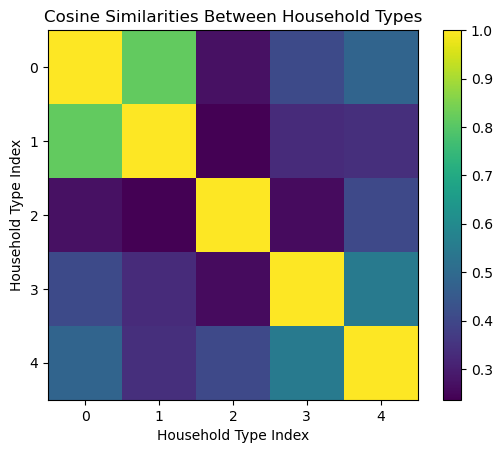

In [3]:
# Create a minimal model instance that doesn't run the main loop, but still loads embeddings.
model = SchellingModel(
    descriptions=example_descriptions,
    grid_size=1,
    num_agents=1,
    similarity_threshold=0.85,
    max_iters=0
)

# Retrieve the  household embeddings from the model
embeddings = model.description_embeddings

# Compute the similarity matrix
sim_matrix = cosine_similarity(embeddings)

# Plot the similarity matrix
plt.imshow(sim_matrix)  # By default uses a color scale
plt.colorbar()
plt.title("Cosine Similarities Between Household Types")
plt.xlabel("Household Type Index")
plt.ylabel("Household Type Index")
plt.savefig("similarity_matrix_example.pdf", bbox_inches='tight', dpi=128)
plt.show()

In [4]:
# Create a list of (type_i, type_j, similarity) for all unique pairs
pairs = []
for i in range(len(example_descriptions)):
    for j in range(i+1, len(example_descriptions)):
        pairs.append((i, j, sim_matrix[i][j]))

# Sort by similarity
pairs.sort(key=lambda x: x[2], reverse=True)

# Take the top 2 most similar
top_5 = pairs[:2]
# Take the bottom 5 least similar
bottom_5 = pairs[-2:]

# Convert to DataFrame
columns = ["Type1 Index", "Type2 Index", "Similarity", "Type1 Description", "Type2 Description"]
rows = []
for (i, j, sim) in top_5:
    rows.append((i, j, sim, example_descriptions[i], example_descriptions[j]))
for (i, j, sim) in bottom_5:
    rows.append((i, j, sim, example_descriptions[i], example_descriptions[j]))

df = pd.DataFrame(rows, columns=columns)

# Print a latex version of the table
print(df.to_latex(index=False, escape=False, column_format='r|r|r|l|l', float_format="%.2f"))

# Show the table
df

\begin{tabular}{r|r|r|l|l}
\toprule
Type1 Index & Type2 Index & Similarity & Type1 Description & Type2 Description \\
\midrule
0 & 1 & 0.82 & A retired couple living alone in a semi-detached house in a suburban area, relying on state pensions and modest savings, strongly supporting the Conservative party & An elderly couple residing in a suburban, semi-detached house, drawing income from their savings and their state pensions, voting for the Conservative party consistently \\
3 & 4 & 0.55 & A large, multi-generational family residing in a terraced house, with the patriarch working as a manual labourer on a zero-hours contract, the matriarch a part-time carer, and several children, identifying as Labour supporters and strongly union-backed & A single parent with three children, living in a council flat, surviving on a tight budget that includes Universal Credit and Child Tax Credits, and staunchly supporting the Labour party, particularly its more left-wing elements \\
2 & 3 & 0.26 & A 

,Type1 Index,Type2 Index,Similarity,Type1 Description,Type2 Description
0,0,1,0.816330,A retired couple living alone in a semi-detach...,"An elderly couple residing in a suburban, semi..."
1,3,4,0.548173,"A large, multi-generational family residing in...","A single parent with three children, living in..."
2,2,3,0.260055,"A young, single professional renting a studio ...","A large, multi-generational family residing in..."
3,1,2,0.236308,"An elderly couple residing in a suburban, semi...","A young, single professional renting a studio ..."


Note: **the plots showing the initial and final agent locations** for these example descriptions are generated by running [schelling_embeddings2.py](schelling_embeddings2.py) and then saving them manually.

### Full embedding set

Read a few hundred household descriptions produced by [create_household_descriptions.py](create_household_descriptions.py).

In [5]:
# Read all files named 'household_descriptions-N.csv' to a single pandas DataFrame
csv_files = glob.glob("household_descriptions-[0-9]*.csv")

# Actually just read one for now
csv_files = ["household_descriptions-350.csv"]

print(f"Reading files: {csv_files}")
household_descriptions = []
for file in csv_files:
    df = pd.read_csv(file, header=None)
    # Append the DataFrame to the list
    household_descriptions.append(df)
# Concatenate all DataFrames into a single DataFrame
household_descriptions_df = pd.concat(household_descriptions, ignore_index=True)
del household_descriptions  # (for tidying, I use this variable later)
# Name the first column 'description' and any other columns can be blank
household_descriptions_df.columns = ['description'] + [f'Unnamed: {i}' for i in range(1, len(household_descriptions_df.columns))]
household_descriptions_df

Reading files: ['household_descriptions-350.csv']


,description
0,Retired couple living in a semi-detached house...
1,"Single mother with two children, residing in a..."
2,"Family of four with two working parents, livin..."
3,"Shared house with five students, located in a ..."
4,Older single person living in a terraced house...
...,...
345,Older single person living in a terraced house...
346,"Couple with two children, residing in a large ..."
347,"Family of four with a single working parent, l..."
348,"Retired couple living in a bungalow, with a co..."


In [6]:
# Need to work with a list from now on
household_descriptions = household_descriptions_df['description'].to_list()

Calculate the embeddings


In [7]:
# Create a minimal model instance. Set grid_size=1, num_agents=1, max_iters=0
# so it doesn't run the main loop, but still loads embeddings.
model = SchellingModel(
    descriptions=household_descriptions,
    grid_size=1,
    num_agents=1,
    similarity_threshold=0.85,
    max_iters=0
)

# Retrieve the 10 household embeddings from the model
embeddings = model.description_embeddings

# Compute the similarity matrix
sim_matrix = cosine_similarity(embeddings)

Embedding shape: (350, 384)


Plot the similarity matrix (a bit big for anything meaningful)

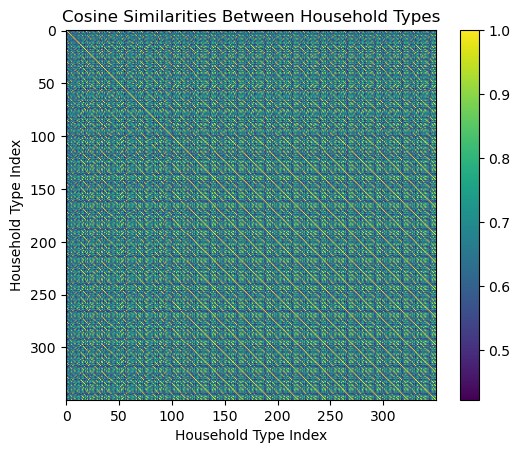

In [8]:
# Plot the similarity matrix
plt.imshow(sim_matrix)  # By default uses a color scale
plt.colorbar()
plt.title("Cosine Similarities Between Household Types")
plt.xlabel("Household Type Index")
plt.ylabel("Household Type Index")
plt.show()

Show the most- and least-similar pairs of households

In [9]:
# Create a list of (type_i, type_j, similarity) for all unique pairs
pairs = []
for i in range(len(household_descriptions)):
    for j in range(i+1, len(household_descriptions)):
        pairs.append((i, j, sim_matrix[i][j]))

# Sort by similarity
pairs.sort(key=lambda x: x[2], reverse=True)

# Take the top 5 most similar
top_5 = pairs[:5]
# Take the bottom 5 least similar
bottom_5 = pairs[-5:]

# Convert to DataFrame
columns = ["Type1 Index", "Type2 Index", "Similarity", "Type1 Description", "Type2 Description"]
rows = []
for (i, j, sim) in top_5:
    rows.append((i, j, sim, household_descriptions[i], household_descriptions[j]))
for (i, j, sim) in bottom_5:
    rows.append((i, j, sim, household_descriptions[i], household_descriptions[j]))

df = pd.DataFrame(rows, columns=columns)

# Show the table
df

,Type1 Index,Type2 Index,Similarity,Type1 Description,Type2 Description
0,180,210,0.999601,"Couple with three children, living in a large ...","Couple with three children, living in a large ..."
1,219,254,0.999590,"Couple with two children, residing in a large ...","Couple with two children, residing in a large ..."
2,212,238,0.999523,"Family of five with two working parents, resid...","Family of five with two working parents, resid..."
3,186,212,0.999503,"Family of five with two working parents, resid...","Family of five with two working parents, resid..."
4,210,242,0.999488,"Couple with three children, living in a large ...","Couple with three children, living in a large ..."
5,55,133,0.425754,"Group of five friends sharing a large house, w...","Single mother with one child, living in a smal..."
6,1,27,0.424936,"Single mother with two children, residing in a...","Group of five friends sharing a large house, w..."
7,55,263,0.423309,"Group of five friends sharing a large house, w...","Single mother with one child, living in a smal..."
8,1,55,0.422988,"Single mother with two children, residing in a...","Group of five friends sharing a large house, w..."
9,55,237,0.422975,"Group of five friends sharing a large house, w...","Single mother with one child, living in a smal..."


## Run the model

Run he model, visualise the changing locations of the agents and then plot a graph to show how happiness changes.

Embedding shape: (350, 384)
Iteration 0: 61 happy agents
Iteration 1: 81 happy agents
Iteration 2: 83 happy agents
Iteration 3: 99 happy agents
Iteration 4: 98 happy agents
Iteration 5: 121 happy agents
Iteration 6: 127 happy agents
Iteration 7: 132 happy agents
Iteration 8: 139 happy agents
Iteration 9: 140 happy agents
Iteration 10: 160 happy agents
Iteration 11: 157 happy agents
Iteration 12: 166 happy agents
Iteration 13: 162 happy agents
Iteration 14: 161 happy agents
Iteration 15: 156 happy agents
Iteration 16: 165 happy agents
Iteration 17: 160 happy agents
Iteration 18: 171 happy agents
Iteration 19: 167 happy agents
Iteration 20: 165 happy agents
Iteration 21: 175 happy agents
Iteration 22: 182 happy agents
Iteration 23: 182 happy agents
Iteration 24: 183 happy agents
Iteration 25: 195 happy agents
Iteration 26: 186 happy agents
Iteration 27: 200 happy agents
Iteration 28: 194 happy agents
Iteration 29: 197 happy agents
Iteration 30: 195 happy agents
Iteration 31: 199 happy ag

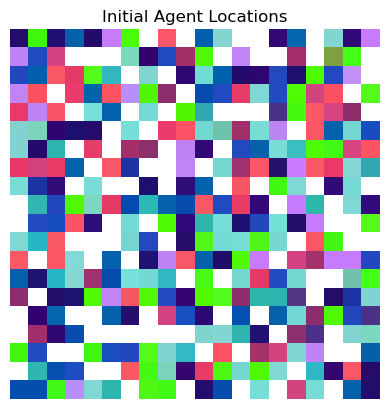

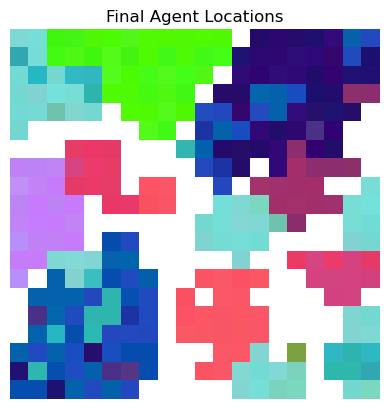

In [10]:

# --- Step 2: Create and run the model
model = SchellingModel(household_descriptions,
                       grid_size=20,
                       num_agents=300,
                       similarity_threshold=0.75,
                       max_iters=200,
                       color_method="pca")

# Save initial positions before running the simulation
initial_positions = [(agent.pos, agent.desc_idx) for agent in model.agents]

# Run the simulation (updates agent positions)
model.run(do_plots=False)

# Save final positions
final_positions = [(agent.pos, agent.desc_idx) for agent in model.agents]

# --- Step 3: Plotting function
def plot_agent_positions(agent_data, title, rgb_map, grid_size=20):
    img = np.ones((grid_size, grid_size, 3))  # white background
    for (x, y), desc_idx in agent_data:
        rgb = rgb_map[desc_idx]
        scaled = (rgb - rgb_map.min()) / (rgb_map.max() - rgb_map.min())
        img[x, y] = scaled
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.savefig(f"{title.replace(" ", "_")}.pdf", bbox_inches='tight', dpi=128)
    plt.show()

# --- Step 4: Show both grids
plot_agent_positions(initial_positions, "Initial Agent Locations", model.rgb_map)
plot_agent_positions(final_positions, "Final Agent Locations", model.rgb_map)


/var/folders/cp/2gftcqdj6w1gfgb05n_ghng40000gr/T/ipykernel_57949/2950375456.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


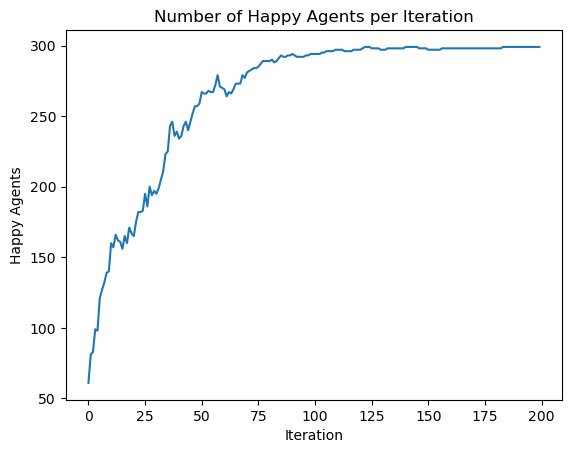

In [11]:
# Plot the happiness graph too
fig = model.plot_happiness(return_fig=True)
fig.savefig("Happiness.pdf", bbox_inches='tight', dpi=128)
fig.show()